<img src="https://raw.githubusercontent.com/GeoscienceAustralia/dea-notebooks/stable/Supplementary_data/dea_logo_wide.jpg" 
     alt="DEA Notebooks logo" 
     style="width:80%;">

# ***Living Earth*** Exploring DEA Land Cover

🔎 Visit [DEA's Knowledge Hub](https://knowledge.dea.ga.gov.au/) for detailed technical information about the datasets and concepts used in this notebook.

<div style="
    border-left: 6px solid var(--jp-success-color1, #4CAF50);
    background-color: rgba(76, 175, 80, 0.15);
    padding: 12px;
    border-radius: 8px;
    font-size: 1rem;
    color: var(--jp-content-font-color1);
">
<b>🚀 How you can run this notebook</b><br><br>
- <b>DEA Sandbox:</b> Eligible users can sign up for the 
<a href="https://sandbox.dea.ga.gov.au/" target="_blank">DEA Sandbox</a> 
that provides free compute and a managed Python environment.<br><br>
- <b>Personal computer:</b> This notebook loads DEA data using <code>odc-stac</code>. 
Data streams via the internet, so can be run locally after installing the required 
<a href="https://pypi.org/project/dea-tools/" target="_blank">DEA Tools</a> Python package, 
e.g. <code>pip install dea-tools[notebooks]</code>.
</div>

<div style="
    border-left: 6px solid var(--jp-info-color1, #2196F3);
    background-color: rgba(33, 150, 243, 0.15);
    padding: 12px;
    border-radius: 8px;
    font-size: 1rem;
    color: var(--jp-content-font-color1);
">
<b>📦 Products used:</b><br>
<a href="https://explorer.dea.ga.gov.au/products/ga_ls_landcover_class_cyear_3" target="_blank">ga_ls_landcover_class_cyear_3</a>
</div>


## Loading up an area based on a box

Through Geoscience Australia's (GA) Digital Earth Australia (DEA) Land Cover, and as part of *Living Earth*, land cover maps have been generated from 1988 to 2024 and for each year from environmental descriptors retrieved or classified entirely from Landsat sensor data and according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (Version 2; https://www.fao.org/4/y7220e/y7220e00.htm).  The spatial resolution of the mapping is 25 m
(see DEA Land Cover) at https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat)

This notebook allows you to explore the land cover maps for anywhere in Australia and for any period of time (noting the maps are generated annually).

You can define an area (based on coordinates of a box) and then you can load up and analyse the land cover and other environmental descriptors (e.g., lifeform, water persistence) used in their construction.  

To assist in the selection of your coordinates, you can click on the image (to be displayed in this notebook) and copy coordinates from the display.  Another option is to go to http://geojson.io and identify coordinates from there.  However, to get started, two areas have been pre-selected.

## Description 

This notebook will demonstrate how to load up an area of the Digital Earth Australia (DEA) land cover map and environmental descriptors used in their construction and description.   

The notebooks take you through the process of:

1. Setting up a time period for analysis.
2. Identifying an area based on a pre-defined coordinates for a rectangle.  
3. Displaying the Level 3 and level 4 land cover maps  

If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/DEA_products/DEA_Land_Cover.ipynb) first. 

***

### Load packages
The cell below imports Python packages that are used for the analysis.
The first command is `%matplotlib inline`, which ensures figures plot correctly in the Jupyter notebook.
The following commands import various functionality: 

* `sys` provides access to helpful support functions in the `dea_plotting` module. 
* `datacube` provides the ability to query and load data.
* `matplotlib` provides the ability to format and manipulate plots.

Note that other libraries are listed but will be used in later iterations of this notebook.  

In [1]:
# Initial imports and setup
import sys
import os, re
import matplotlib.pyplot as plt
from matplotlib import colors as mcolours

import xarray as xr
import numpy as np

import odc.stac
import pystac_client
from odc.geo import BoundingBox
from odc.geo.cog import write_cog
from odc.geo.xr import assign_crs

from dea_tools.plotting import display_map
from dea_tools.landcover import lc_colourmap, make_colourbar, plot_land_cover


## Connect to DEA's STAC API
This allows us to search for data using DEA's STAC API (refer to the SpatioTemporal Asset Catalogue guide for details).

To load data, we must also configure access to DEA's Amazon S3 buckets using `odc.stac.configure_s3_access`. If launching a Dask client with `dea_tools.dask.create_local_dask_cluster()`, this is done automatically.

In [2]:
# Configure data access
odc.stac.configure_s3_access(cloud_defaults=True, aws_unsigned=True)

# Connect to STAC API
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

## Analysis Parameters

Set the product, spatial boundary, time range, and spatial resolution and projection for the data you want to load

In [3]:
product='ga_ls_landcover_class_cyear_3'

# Set the range of dates for the analysis
time_range = ("2020", "2024")

# Coordinates for Broome, Western Australia
#central_lat = -18.10
#central_lon = 122.32

# Sydney, New South Wales, Australia
# central_lat = -33.9
# central_lon = 151.24

# Brisbane, Queensland, Australia
central_lat = -27.47
central_lon = 153.02

buffer = 0.5
resolution=30
crs='EPSG:3577'

## Query the stac catalog for items relating to our query

In [4]:
#set up a bounding box for our stac query 
bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs=crs
)
bbox_query = bbox.bbox

# Search the catalog for matching S2 data
query = catalog.search(
    bbox=bbox_query,
    collections=[product],
    datetime=time_range
    )

items = list(query.items()) #convert to list
print(f"Found: {len(items):d} datasets")

Found: 25 datasets


After choosing the study area, it can be useful to visualise it on an interactive map.
This provides a sense of scale.
> **Note**: The interactive map also returns latitude and longitude values when clicked.
You can use this to generate new latitude and longitude values to try without leaving the notebook.

In [5]:
# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)
display_map(x=study_area_lon, y=study_area_lat)

### Load DEA land cover
This section reads the data from the data cube, with this including the land cover and environmental descriptor measurements (ga_ls_landcover_class_cyear_2) and the output Coordinate Reference System (CRS; see https://epsg.io/?q= and also https://datacarpentry.org/organization-geospatial/03-crs.html))

In [6]:
#now load the data with odc-stac
lc = odc.stac.load(
    items, #stac items
    bands=["level3", "level4"], #theses are the only two measurements
    crs=crs,
    resolution=resolution,
    groupby="solar_day",
    bbox=bbox, #area to load over
)

Following the load step, printing the `lc` `xarray.Dataset` object will give you insight into all of the data that was loaded.
Do this by running the next cell.

The data are represented by the following aspects:
- `Dimensions`: the names of data dimensions, frequently `time`, `x` and `y`, and number of entries in each
- `Coordinates`: the coordinate values for each point in the data cube, including time.
- `Data variables`: the observations loaded, with this including the environmental descriptors and full land cover classification.
- `Attributes`: additional useful information about the data, such as the `crs` (coordinate reference system)

In [7]:
lc

<xarray.Dataset> Size: 646MB
Dimensions:      (y: 4223, x: 3823, time: 5)
Coordinates:
  * y            (y) float64 34kB -3.085e+06 -3.085e+06 ... -3.211e+06
  * x            (x) float64 31kB 1.986e+06 1.986e+06 ... 2.1e+06 2.1e+06
    spatial_ref  int32 4B 3577
  * time         (time) datetime64[ns] 40B 2020-01-01 2021-01-01 ... 2024-01-01
Data variables:
    level3       (time, y, x) float32 323MB 112.0 112.0 112.0 ... 220.0 220.0
    level4       (time, y, x) float32 323MB 34.0 34.0 34.0 ... 101.0 101.0 101.0

## Plot Level 3 descriptors

In [8]:
# Define a colour scheme for the Level 3
LEVEL3_COLOUR_SCHEME = {
    111: (172, 188, 45, 255, "Cultivated terrestrial vegetation"),
    112: (14, 121, 18, 255, "Natural terrestrial vegetation"),
    124: (30, 191, 121, 255, "Natural aquatic vegetation"),
    215: (218, 92, 105, 255, "Artificial surface"),
    216: (243, 171, 105, 255, "Natural bare surface"),
    220: (77, 159, 220, 255, "Water"),
    255: (255, 255, 255, 255, "No Data"),
}

In [9]:
def plot_layer(colours, data, col_wrap, size=5):
    colour_arr = []
    for key, value in colours.items():
        colour_arr.append(np.array(value[:-1]) / 255)
 
    cmap = mcolours.ListedColormap(colour_arr)
    bounds = list(colours)
    bounds.append(256) # add upper bound to make sure highest value (255) included in last colour bin
    norm = mcolours.BoundaryNorm(np.array(bounds) - 0.1, cmap.N)
    labels = {'ticks' : [111,112,124,215,216,220,255],}

    if len(data.time) == 1: 
        # Plot the provided layer
        im = data.isel(time=0).plot(
        cmap=cmap, norm=norm, add_colorbar=True, size=size, cbar_kwargs=labels
        )

    else:
        # Plot the provided layer
        im = data.plot(
        cmap=cmap, norm=norm, add_colorbar=True, col="time", col_wrap=col_wrap, size=size, cbar_kwargs=labels
        )
 
    return im

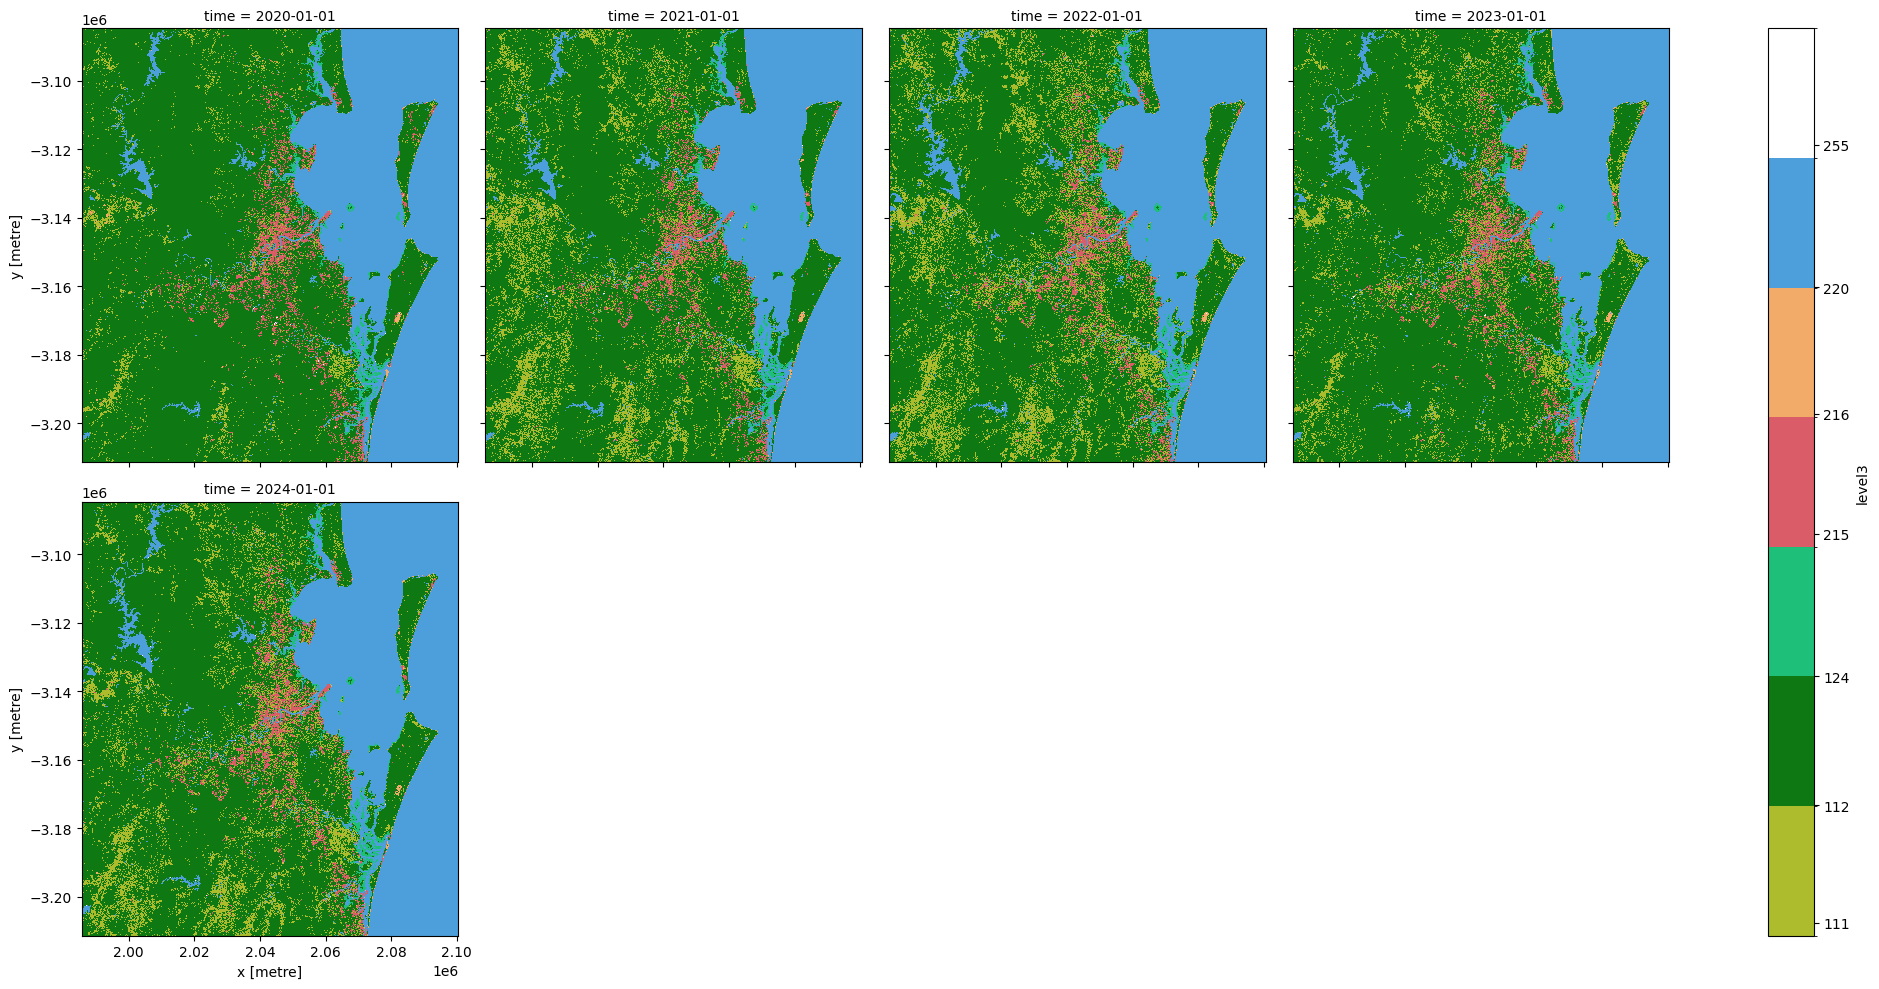

In [10]:
plot_layer(LEVEL3_COLOUR_SCHEME, lc.level3, col_wrap=4);

## Plot Level 4: Environmental descriptors

We can use the pre-canned function, `dea-tools.landcover.plot_land_cover`

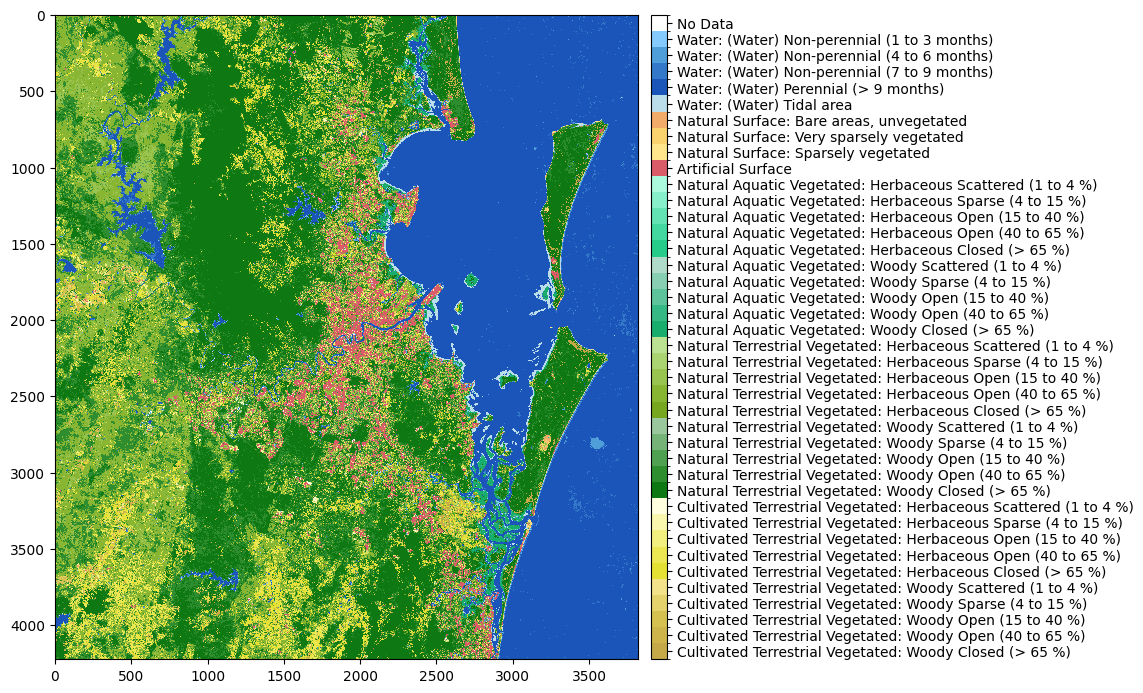

In [11]:
plot_land_cover(lc.level4, year='2024', width_pixels=600);

In [ ]:
lc.level4[3]
unique_vals = np.unique(lc.level4.values)

print(unique_vals)

In [ ]:
lc.level3[1]
unique_vals = np.unique(lc.level3.values)

print(unique_vals)

## Plotting individual descriptors

Two examples are shown below, see the knowledge hub for full details: https://knowledge.dea.ga.gov.au/data/product/dea-land-cover-landsat/?tab=description

### Lifeform 

Describes the predominant vegetation type in vegetated areas. It is categorised as follows:

* Not applicable (such as no data or not vegetated)
* Herbaceous vegetation (grasses, forbs)
* Woody vegetation (trees, shrubs)

Lifeform provides detail to the following Level 3 classes: Cultivated Terrestrial Vegetation (111), Natural Terrestrial Vegetation (112), and Natural Aquatic Vegetation (124).

In [ ]:
plot_land_cover(lc.level4, measurement='lifeform', year='2024');

## Vegetation cover

Vegetation cover describes the percentage of cover in vegetated areas. It is categorised as follows:

* Not applicable (such as in bare areas)
* Scattered (1 to 4%)
* Sparse (4 to 15%)
* Open (15 to 40%)
* Open (40 to 65%) 
* Closed (>65%) 

Vegetation cover provides detail to the following Level 3 classes: Cultivated Terrestrial Vegetation (111), Natural Terrestrial Vegetation (112), and Natural Aquatic Vegetation (124).

In [ ]:
plot_land_cover(lc.level4, measurement='vegetation_cover',  year='2024');

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Discord chat](https://discord.com/invite/4hhBQVas5U) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2025